## UCD Datathon Credit Risk Modelling

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Modelling et Features
from sklearn.model_selection import KFold, train_test_split, cross_val_score, cross_validate, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV, SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer,accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE, SMOTENC, RandomOverSampler
import optuna

# ignore all warnings
warnings.filterwarnings('ignore')

plt.rcParams["font.family"] = "Times New Roman"

In [378]:
data = pd.read_csv("credit_traindata.csv")
data.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,bad


- checking_account_status: status of the checking account, which can be 'no checking account', '< 0 DM', '0 <= ... < 200 DM', or '>= 200 DM / salary for at least 1 year'
- duration: duration in months
- credit_history: credit history, which can be 'no credits taken/ all credits paid back duly', 'all credits at this bank paid back duly', 'existing credits paid back duly till now', 'delay in paying off in the past', or 'critical account/other credits existing (not at this bank)'
- purpose: purpose of credit, which can be 'car (new)', 'car (used)', 'furniture/equipment', 'radio/television', 'domestic appliances', 'repairs', 'education', 'vacation', 'retraining', or 'business'
- credit_amount: credit amount in DM
- savings_account/bonds: savings account/bonds, which can be 'no savings account', '< 100 DM', '100 <= ... < 500 DM', '500 <= ... < 1000 DM', or '>= 1000 DM'
- present_employment_since: present employment since, which can be 'unemployed', '< 1 year', '1 <= ... < 4 years', '4 <= ... < 7 years', or '>= 7 years'
- installment_rate: installment rate in percentage of disposable income
- personal_status_sex: personal status and sex, which can be 'male : divorced/separated', 'female : divorced/separated/married', 'male : single', or 'male : married/widowed'
- other_debtors/guarantors: other debtors/guarantors, which can be 'none', 'co-applicant', or 'guarantor'
- present_residence_since: present residence since in years
- property: property, which can be 'real estate', 'if not A121 : building society savings agreement/ life insurance', 'if not A121/A122 : car or other, not in attribute 6', or 'unknown / no property'
- age: age in years
- other_installment_plans: other installment plans, which can be 'bank', 'stores', or 'none'
- housing: housing, which can be 'rent', 'own', or 'for free'
- number_of_existing_credits: number of existing credits at this bank
- job: job, which can be 'unemployed/ unskilled - non-resident', 'unskilled - resident', 'skilled employee / official', or 'management/ self-employed/highly qualified employee/officer'
- number_of_dependents: number of people being liable to provide maintenance for
- telephone: whether the customer has a telephone or not
- foreign_worker: whether the customer is a foreign worker or not

In [379]:
# We see this is a merged feature, therefore we will expand it out into both a relationship and sex status
print(data.personal_status.tail())

data[['sex', 'relationship_status']] = data['personal_status'].str.split(' ', 1, expand=True)

# Drop the original "personal_status" column
data.drop('personal_status', axis=1, inplace=True)

print("\n       NEW FEATURES \n", data.iloc[:,-2:].tail())

793          male div/sep
794           male single
795    female div/dep/mar
796           male single
797    female div/dep/mar
Name: personal_status, dtype: object

       NEW FEATURES 
         sex relationship_status
793    male             div/sep
794    male              single
795  female         div/dep/mar
796    male              single
797  female         div/dep/mar


In [380]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798 entries, 0 to 797
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   checking_status         798 non-null    object
 1   duration                798 non-null    int64 
 2   credit_history          798 non-null    object
 3   purpose                 798 non-null    object
 4   credit_amount           798 non-null    int64 
 5   savings_status          798 non-null    object
 6   employment              798 non-null    object
 7   installment_commitment  798 non-null    int64 
 8   other_parties           798 non-null    object
 9   residence_since         798 non-null    int64 
 10  property_magnitude      798 non-null    object
 11  age                     798 non-null    int64 
 12  other_payment_plans     798 non-null    object
 13  housing                 798 non-null    object
 14  existing_credits        798 non-null    int64 
 15  job   

In [381]:
data.isnull().sum()

checking_status           0
duration                  0
credit_history            0
purpose                   0
credit_amount             0
savings_status            0
employment                0
installment_commitment    0
other_parties             0
residence_since           0
property_magnitude        0
age                       0
other_payment_plans       0
housing                   0
existing_credits          0
job                       0
num_dependents            0
own_telephone             0
foreign_worker            0
class                     0
sex                       0
relationship_status       0
dtype: int64

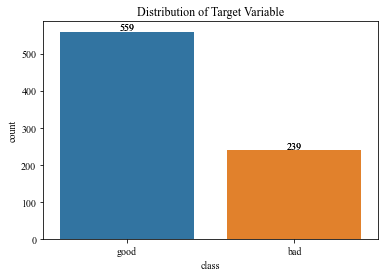

In [382]:
sns.countplot(x='class', data=data)
plt.title('Distribution of Target Variable')
plt.xlabel('Creditability')
plt.ylabel('Count')

# Add count labels
for p in sns.countplot(x='class', data=data).patches:
    count = p.get_height()
    plt.text(p.get_x()+p.get_width()/2., count + 3, count, ha='center')
plt.show()

In [383]:
# Lets take a look at some of these continuous/discrete variables
round(data.describe(),2)

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,798.00,798.00,798.00,798.00,798.00,798.00,798.00
mean,20.66,3196.13,2.96,2.84,35.38,1.40,1.15
std,12.16,2734.07,1.13,1.11,11.47,0.57,0.36
min,4.00,250.00,1.00,1.00,19.00,1.00,1.00
25%,12.00,1344.50,2.00,2.00,27.00,1.00,1.00
50%,18.00,2286.00,3.00,3.00,33.00,1.00,1.00
75%,24.00,3914.75,4.00,4.00,41.00,2.00,1.00
max,72.00,15945.00,4.00,4.00,75.00,4.00,2.00


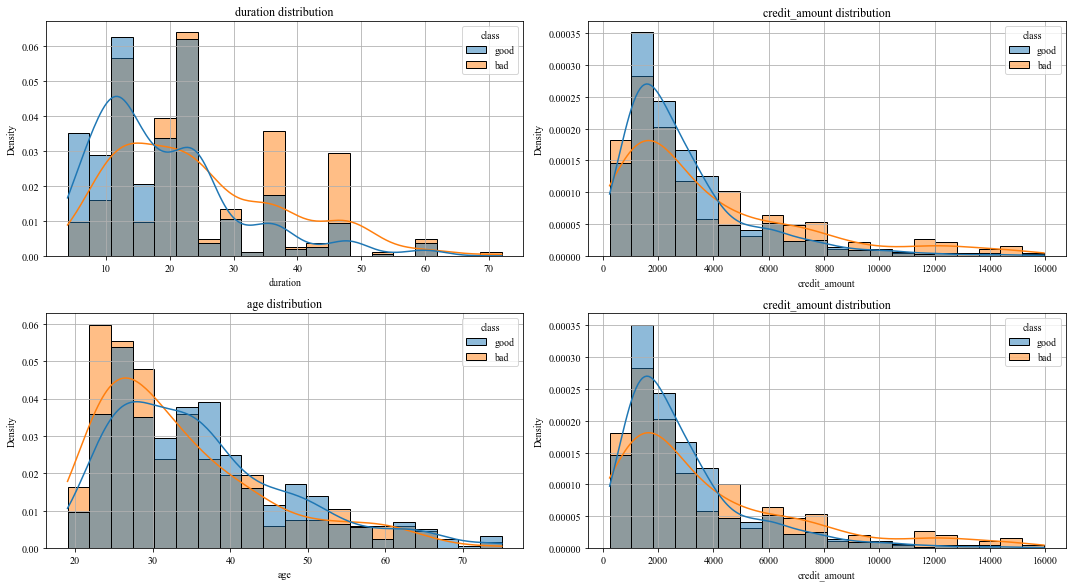

In [384]:
cont_vars = ["duration", "credit_amount", "age", "credit_amount"]

# Plot distributions for each variable, grouped by class
plt.figure(figsize=(15, 20))
for i, var in enumerate(cont_vars):
    plt.subplot(5, 2, i+1)
    plt.title(f"{var} distribution")
    sns.histplot(data=data, x=var, hue='class', kde=True, stat='density', common_norm=False, alpha=0.5, bins=20)
    plt.axvline(x=data[data["class"]==0][var].mean(), color='blue', linestyle='--', linewidth=2)
    plt.axvline(x=data[data["class"]==1][var].mean(), color='orange', linestyle='--', linewidth=2)
    plt.grid()
    plt.tight_layout()

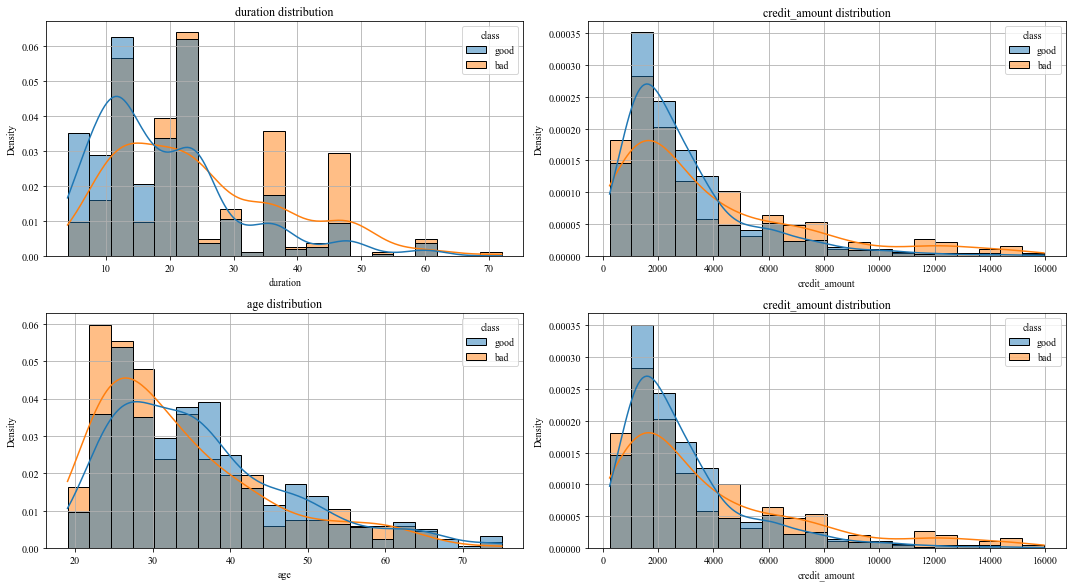

In [386]:
#cont_vars = data.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Plot distributions for each variable, grouped by class
plt.figure(figsize=(15, 20))
for i, var in enumerate(cont_vars):
    plt.subplot(5, 2, i+1)
    plt.title(f"{var} distribution")
    sns.histplot(data=data, x=var, hue='class', kde=True, stat='density', common_norm=False, alpha=0.5, bins=20)
    plt.grid()
    plt.tight_layout()

From here we can immediately observe that number of dependents, existing credits and residency have very little decerning features in the comparison of good and bad credit customers, while we wont immediately cut them we will test later. 

### Text/Categorical Features

While we have observed these from our plotting and graphs, we must employ statistical tests to ensure we are not reducing our models power by removing said feature. We note however the complexity trade-off to improve generalisation. To observe this we are goin to compare to a model employing all our features using one-hot encoding.  

### Hypothesis Testing 

Some of these features are very explainable, for example, age, duration, sex and credit amount are all basic variables critical to this classification task.

Lets see some of these categorical/text features:

In [387]:
categoricals = data.select_dtypes(include=["object"]).columns.tolist()

for column in categoricals:
    print("\n",column, ":", data[column].unique())


 checking_status : ['<0' '0<=X<200' 'no checking' '>=200']

 credit_history : ['critical/other existing credit' 'existing paid' 'delayed previously'
 'no credits/all paid' 'all paid']

 purpose : ['radio/tv' 'education' 'furniture/equipment' 'new car' 'used car'
 'business' 'domestic appliance' 'repairs' 'other' 'retraining']

 savings_status : ['no known savings' '<100' '500<=X<1000' '>=1000' '100<=X<500']

 employment : ['>=7' '1<=X<4' '4<=X<7' 'unemployed' '<1']

 other_parties : ['none' 'guarantor' 'co applicant']

 property_magnitude : ['real estate' 'life insurance' 'no known property' 'car']

 other_payment_plans : ['none' 'bank' 'stores']

 housing : ['own' 'for free' 'rent']

 job : ['skilled' 'unskilled resident' 'high qualif/self emp/mgmt'
 'unemp/unskilled non res']

 own_telephone : ['yes' 'none']

 foreign_worker : ['yes' 'no']

 class : ['good' 'bad']

 sex : ['male' 'female']

 relationship_status : ['single' 'div/dep/mar' 'div/sep' 'mar/wid']


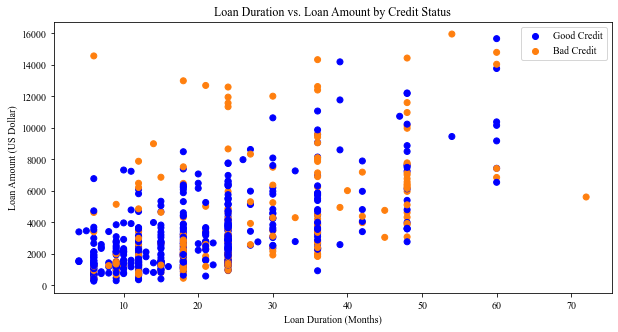

In [421]:
plt.figure(figsize = (10,5))
plt.scatter(data['duration'], data['credit_amount'], c=data['class'].map({'good': 'blue', 'bad': 'tab:orange'}))

plt.xlabel('Loan Duration (Months)')
plt.ylabel('Loan Amount (US Dollar)')
plt.title('Loan Duration vs. Loan Amount by Credit Status')

good_legend = plt.scatter([],[], c='blue')
bad_legend = plt.scatter([],[], c='tab:orange')
plt.legend((good_legend, bad_legend), ('Good Credit', 'Bad Credit'))

plt.show()

In [388]:
#Let's look the Credit Amount column
interval = (18, 25, 35, 60, 120)

cats = ['Student', 'Young', 'Adult', 'Senior']
data["Age_cat"] = pd.cut(data.age, interval, labels=cats)


df_good = data[data["class"] == 'good']
df_bad = data[data["class"] == 'bad']

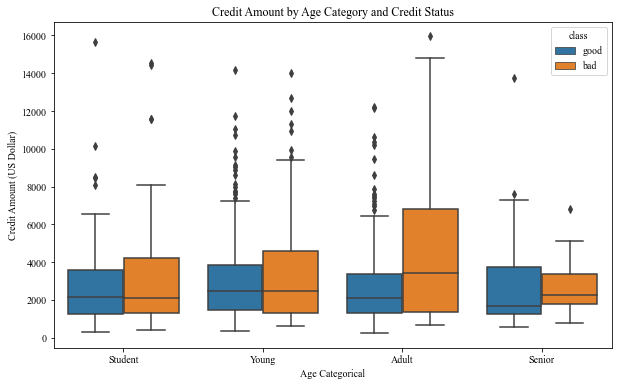

In [389]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(x='Age_cat', y='credit_amount', hue='class',
            data=data, ax=ax)

ax.set_xlabel('Age Categorical')
ax.set_ylabel('Credit Amount (US Dollar)')
ax.set_title('Credit Amount by Age Category and Credit Status')

plt.show()

In [390]:
df_good

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,other_parties,residence_since,...,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class,sex,relationship_status,Age_cat
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,none,4,...,own,2,skilled,1,yes,yes,good,male,single,Senior
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,none,3,...,own,1,unskilled resident,2,none,yes,good,male,single,Adult
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,guarantor,4,...,for free,1,skilled,2,none,yes,good,male,single,Adult
5,no checking,36,existing paid,education,9055,no known savings,1<=X<4,2,none,4,...,for free,1,unskilled resident,2,yes,yes,good,male,single,Young
6,no checking,24,existing paid,furniture/equipment,2835,500<=X<1000,>=7,3,none,4,...,own,1,skilled,1,none,yes,good,male,single,Adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
792,no checking,6,critical/other existing credit,furniture/equipment,1221,no known savings,1<=X<4,1,none,2,...,own,2,skilled,1,none,yes,good,male,mar/wid,Young
793,>=200,24,existing paid,furniture/equipment,2892,<100,>=7,3,none,4,...,for free,1,skilled,1,none,yes,good,male,div/sep,Adult
794,no checking,24,existing paid,furniture/equipment,3062,500<=X<1000,>=7,4,none,3,...,rent,1,skilled,1,yes,yes,good,male,single,Young
795,no checking,9,existing paid,furniture/equipment,2301,100<=X<500,<1,2,none,4,...,rent,1,skilled,1,none,yes,good,female,div/dep/mar,Student


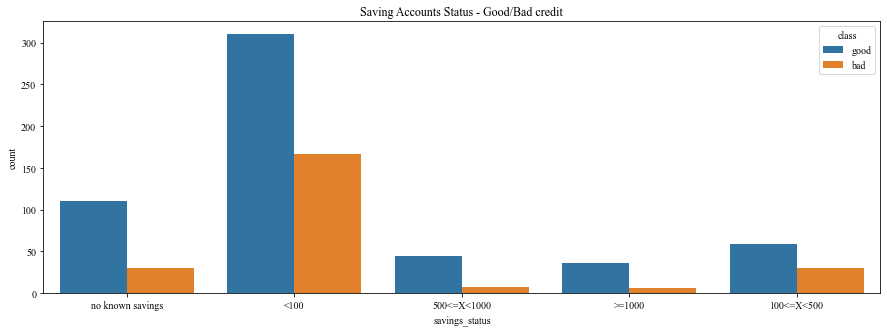

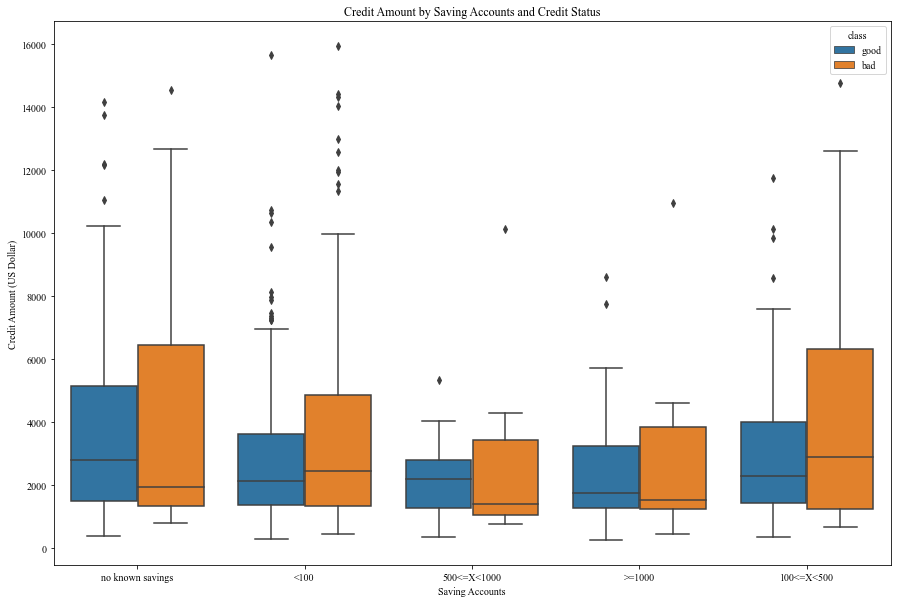

In [412]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.countplot(x='savings_status', hue='class', data=data, ax=ax)
ax.set_title('Saving Accounts Status - Good/Bad credit')

# Create boxplot
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(x='savings_status', y='credit_amount', hue='class', data=data)
ax.set_xlabel('Saving Accounts')
ax.set_ylabel('Credit Amount (US Dollar)')
ax.set_title('Credit Amount by Saving Accounts and Credit Status')

plt.show()

In [11]:
# Let's encode 
from sklearn import preprocessing

binarizer = preprocessing.LabelBinarizer()

binaries = ["foreign_worker", "own_telephone", "class", "sex"]

for var in binaries:
    data[var] = binarizer.fit_transform(data[var])

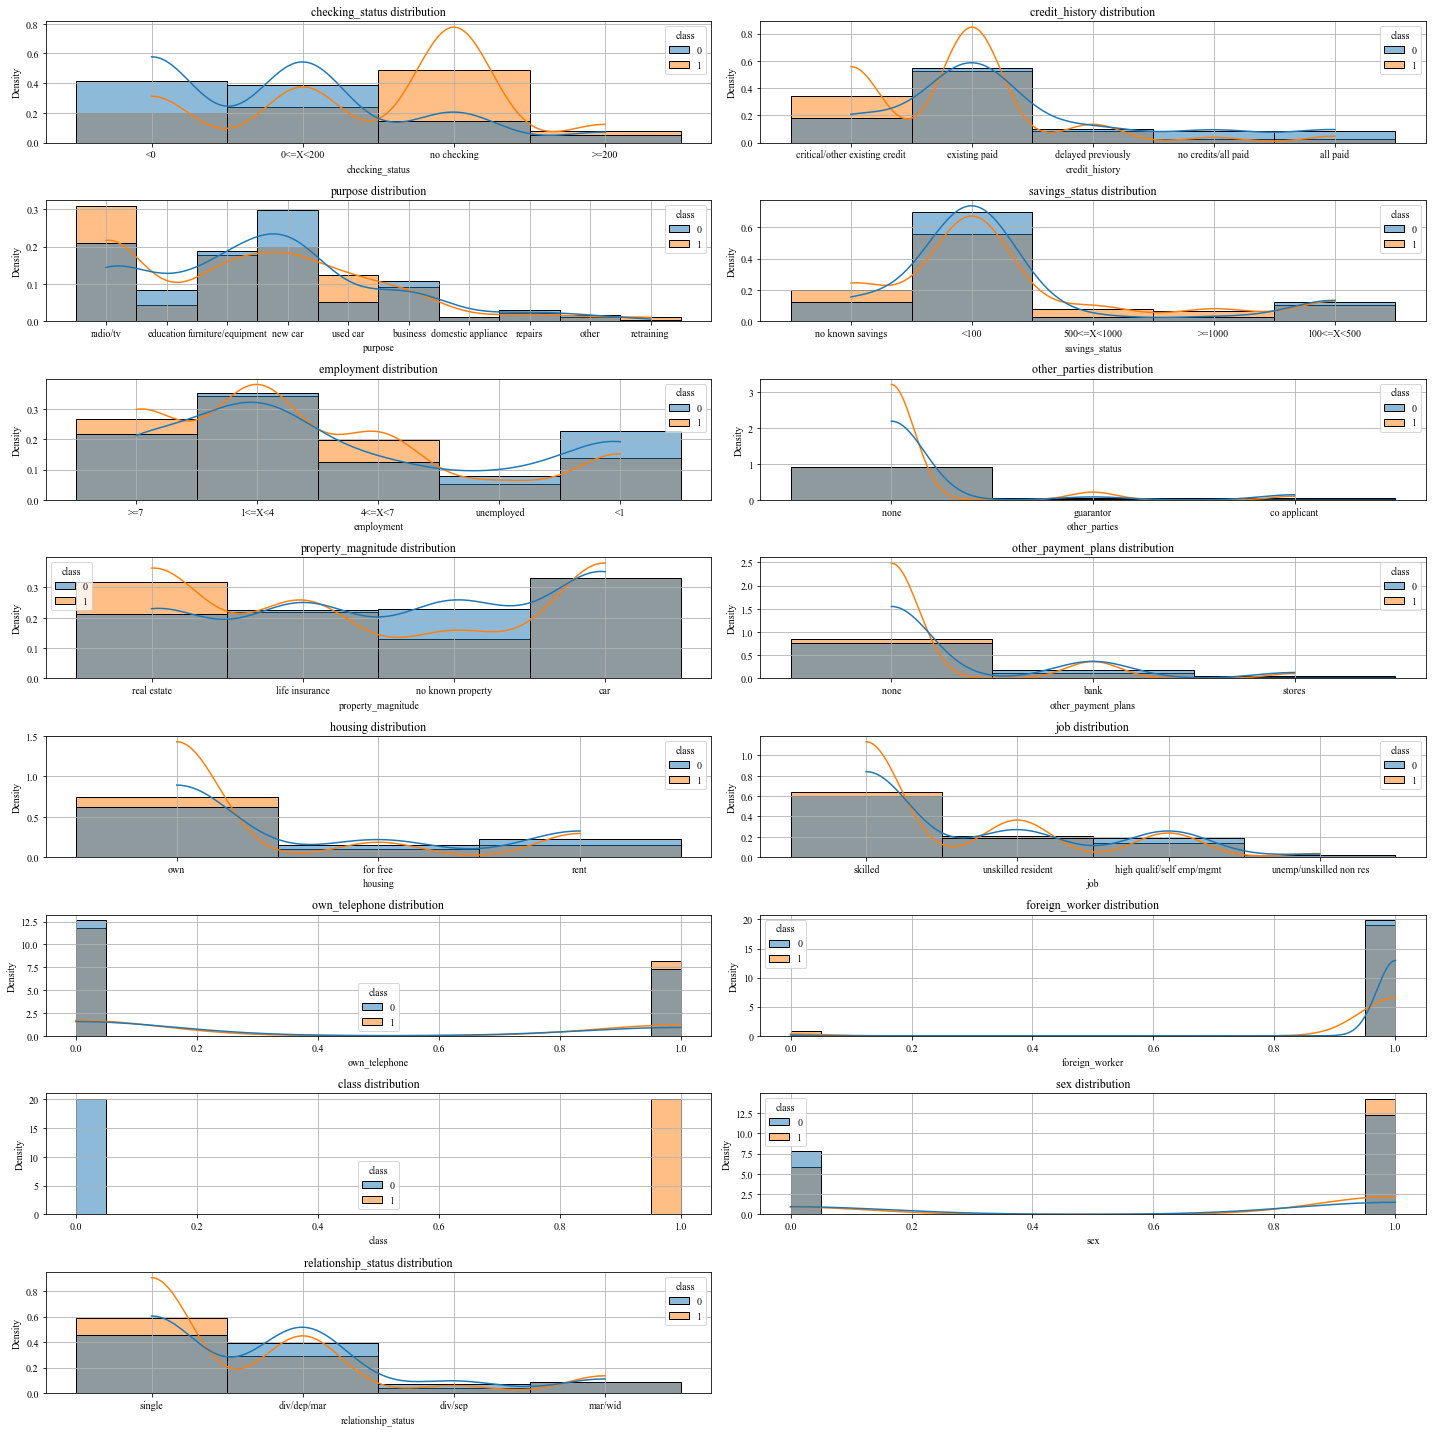

In [12]:
# Plot distributions for each variable, grouped by class
plt.figure(figsize=(20, 20))
for i, var in enumerate(categoricals):
    plt.subplot(8, 2, i+1)
    plt.title(f"{var} distribution")
    sns.histplot(data=data, x=var, hue='class', kde=True, stat='density', common_norm=False, alpha=0.5, bins=20)
    plt.grid()
    plt.tight_layout()

## Feature Selection

### Lets now encode some features

In [13]:
def one_hot_encoder(df, nan_as_category=False, sep='_'):
    """
    One-hot encode categorical columns in a pandas DataFrame.

    Parameters:
    df (pandas.DataFrame): The input DataFrame to encode.
    nan_as_category (bool): If True, treat NaN values as a separate category. Default is False.
    sep (str): The separator character to use when creating new column names from multi-level columns. Default is '_'.

    Returns:
    (pandas.DataFrame): The encoded DataFrame.
    (list): A list of new column names created during encoding.
    """

    # Check if the input DataFrame is empty or has no categorical columns
    if df.empty:
        raise ValueError('Input DataFrame is empty.')
    if not any(df.dtypes == 'object'):
        raise ValueError('Input DataFrame has no categorical columns to encode.')

    # Save original column names and find categorical columns
    original_columns = list(df.columns)
    categorical_columns = df.select_dtypes(include=['object']).columns
    df_encoded = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category, prefix_sep=sep)
    new_columns = [c for c in df_encoded.columns if c not in original_columns]
    df_encoded[new_columns] = df_encoded[new_columns].astype(int)

    return df_encoded, new_columns

In [14]:
data_encoded, new_columns = one_hot_encoder(data)
new_col = [col.replace("<", "_").replace(">", "_") for col in data_encoded.columns]
data_encoded.columns = new_col
data_encoded.head()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,own_telephone,foreign_worker,class,...,housing_own,housing_rent,job_high qualif/self emp/mgmt,job_skilled,job_unemp/unskilled non res,job_unskilled resident,relationship_status_div/dep/mar,relationship_status_div/sep,relationship_status_mar/wid,relationship_status_single
0,6,1169,4,4,67,2,1,1,1,1,...,1,0,0,1,0,0,0,0,0,1
1,48,5951,2,2,22,1,1,0,1,0,...,1,0,0,1,0,0,1,0,0,0
2,12,2096,2,3,49,1,2,0,1,1,...,1,0,0,0,0,1,0,0,0,1
3,42,7882,2,4,45,1,2,0,1,1,...,0,0,0,1,0,0,0,0,0,1
4,24,4870,3,4,53,2,2,0,1,0,...,0,0,0,1,0,0,0,0,0,1


## Train/Test Split

In [55]:
# Creating development and test sets for future evaluation 

development_set, test_set = train_test_split(data_encoded, test_size=0.1)

scaler = MinMaxScaler()

# Fit the scaler to the entire training set
scaler.fit(development_set[cont_vars])

# Transform the continuous variables using the fitted scaler
development_set[cont_vars] = scaler.transform(development_set[cont_vars])

development_set = development_set.reset_index(drop=True)

development_set.tail()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,own_telephone,foreign_worker,class,...,housing_own,housing_rent,job_high qualif/self emp/mgmt,job_skilled,job_unemp/unskilled non res,job_unskilled resident,relationship_status_div/dep/mar,relationship_status_div/sep,relationship_status_mar/wid,relationship_status_single
713,0.785714,0.430010,1,1,0.267857,2,1,1,1,0,...,1,0,0,1,0,0,0,0,1,0
714,0.142857,0.059573,3,2,0.142857,2,1,0,1,1,...,1,0,0,1,0,0,1,0,0,0
715,0.035714,0.011341,2,1,0.535714,1,1,1,1,1,...,1,0,0,1,0,0,1,0,0,0
716,0.142857,0.112265,4,2,0.750000,1,1,0,1,1,...,1,0,0,1,0,0,1,0,0,0
717,0.785714,0.392864,4,3,0.714286,1,1,0,1,0,...,0,1,0,1,0,0,1,0,0,0


In [56]:
development_set.shape

(718, 61)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 [Text(0, 0.5, 'class'),
  Text(0, 1.5, 'checking_status_no checking'),
  Text(0, 2.5, 'checking_status__0'),
  Text(0, 3.5, 'duration'),
  Text(0, 4.5, 'credit_history_critical/other existing credit'),
  Text(0, 5.5, 'savings_status__100'),
  Text(0, 6.5, 'credit_history_no credits/all paid'),
  Text(0, 7.5, 'housing_own'),
  Text(0, 8.5, 'credit_amount'),
  Text(0, 9.5, 'checking_status_0_=X_200'),
  Text(0, 10.5, 'property_magnitude_no known property')])

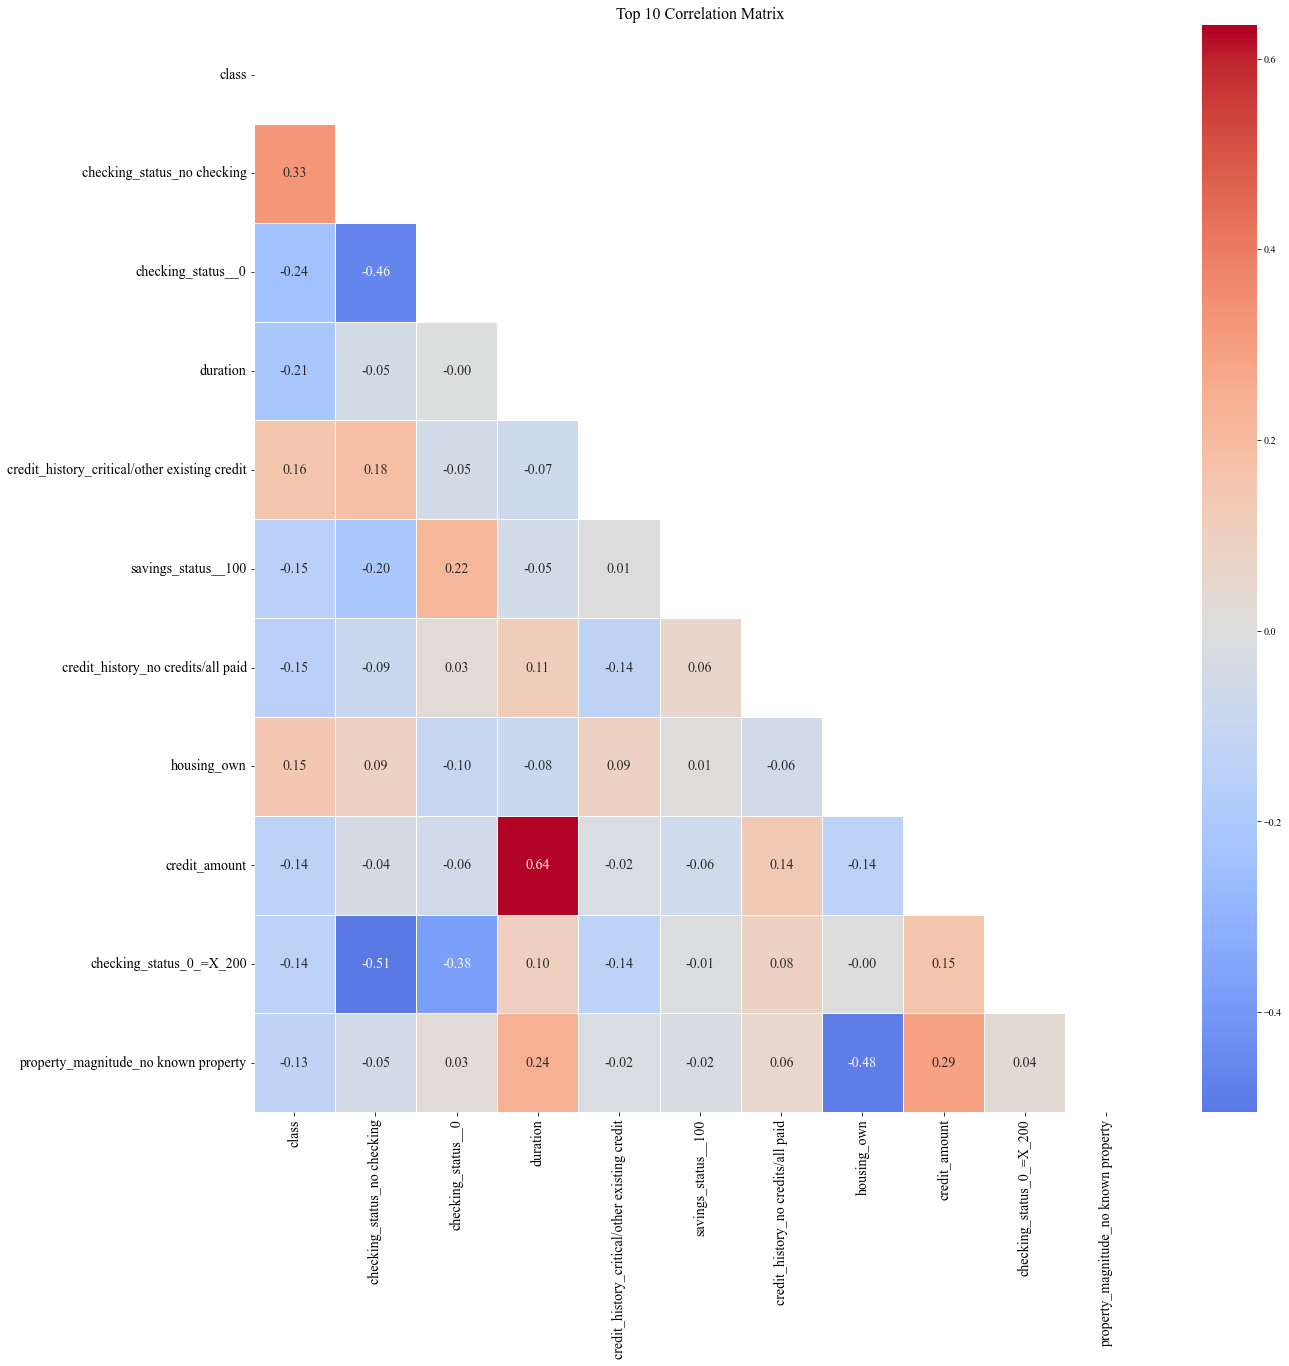

In [65]:
plt.figure(figsize=(20, 20))
corr = development_set.corr()
top_corr_features = abs(corr['class']).sort_values(ascending=False).head(11).index
top_corr = development_set[top_corr_features].corr()
mask = np.triu(np.ones_like(top_corr, dtype=bool))
sns.heatmap(top_corr, mask=mask, cmap='coolwarm', linewidths=0.5, annot=True, fmt='.2f', cbar=True, center=0, annot_kws={"fontsize":14})
plt.title('Top 10 Correlation Matrix', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [58]:
from sklearn.preprocessing import PolynomialFeatures

# Define the original features and the columns to transform
original_features = ['duration','checking_status_no checking','checking_status__0', 'credit_amount','checking_status_0_=X_200']
poly_features = development_set[original_features]

# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree=2)

# Transform the features
poly_features = poly_transformer.fit_transform(poly_features)

# Get the feature names and create a dataframe
poly_feature_names = poly_transformer.get_feature_names(original_features)
poly_features_df = pd.DataFrame(poly_features, columns=poly_feature_names)

print(poly_features_df.shape)
poly_features_df.tail()

(718, 21)


,1,duration,checking_status_no checking,checking_status__0,credit_amount,checking_status_0_=X_200,duration^2,duration checking_status_no checking,duration checking_status__0,duration credit_amount,...,checking_status_no checking^2,checking_status_no checking checking_status__0,checking_status_no checking credit_amount,checking_status_no checking checking_status_0_=X_200,checking_status__0^2,checking_status__0 credit_amount,checking_status__0 checking_status_0_=X_200,credit_amount^2,credit_amount checking_status_0_=X_200,checking_status_0_=X_200^2
713,1.0,0.785714,0.0,1.0,0.430010,0.0,0.617347,0.000000,0.785714,0.337865,...,0.0,0.0,0.000000,0.0,1.0,0.430010,0.0,0.184908,0.000000,0.0
714,1.0,0.142857,1.0,0.0,0.059573,0.0,0.020408,0.142857,0.000000,0.008510,...,1.0,0.0,0.059573,0.0,0.0,0.000000,0.0,0.003549,0.000000,0.0
715,1.0,0.035714,0.0,1.0,0.011341,0.0,0.001276,0.000000,0.035714,0.000405,...,0.0,0.0,0.000000,0.0,1.0,0.011341,0.0,0.000129,0.000000,0.0
716,1.0,0.142857,1.0,0.0,0.112265,0.0,0.020408,0.142857,0.000000,0.016038,...,1.0,0.0,0.112265,0.0,0.0,0.000000,0.0,0.012603,0.000000,0.0
717,1.0,0.785714,0.0,0.0,0.392864,1.0,0.617347,0.000000,0.000000,0.308679,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.154342,0.392864,1.0


In [59]:
# Add the polynomial features to the original dataframe
#development_set = pd.concat([development_set, poly_features_df], axis=1)
development_set.shape

(718, 61)

In [66]:
X_train = development_set.drop("class", axis=1)
y_train = development_set["class"]

# Chi-squared feature selection
chi2_scores, p_values = chi2(X_train, y_train)
feature_scores = pd.DataFrame({"Feature": X_train.columns, "Score": chi2_scores, "p-value": p_values})
feature_scores.sort_values(by="Score", ascending=False, inplace=True)
selected_features_chi2 = feature_scores[feature_scores["p-value"] < 0.05]["Feature"].tolist()

print(selected_features_chi2)

['checking_status_no checking', 'checking_status__0', 'credit_history_no credits/all paid', 'credit_history_critical/other existing credit', 'credit_history_all paid', 'property_magnitude_no known property', 'checking_status_0_=X_200', 'purpose_used car', 'savings_status__100', 'property_magnitude_real estate', 'savings_status_no known savings', 'housing_rent', 'employment__1', 'purpose_new car', 'purpose_education', 'purpose_radio/tv', 'savings_status_500_=X_1000', 'housing_for free', 'duration', 'savings_status__=1000', 'installment_commitment', 'housing_own', 'other_payment_plans_bank']


In [67]:
len(selected_features_chi2)

23

In [68]:
# Creating a random forest classifier
rfc = RandomForestClassifier()

# Performing RF-RFE using 10-fold cross-validation
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(n_splits=10), scoring = 'f1')
rfecv.fit(X_train, y_train)

# Printing the results
print("Optimal number of features: %d" % rfecv.n_features_)
print("Selected features: %s" % X_train.columns[rfecv.support_])

Optimal number of features: 49
Selected features: Index(['duration', 'credit_amount', 'installment_commitment',
       'residence_since', 'age', 'existing_credits', 'num_dependents',
       'own_telephone', 'sex', 'checking_status_0_=X_200',
       'checking_status__0', 'checking_status__=200',
       'checking_status_no checking', 'credit_history_all paid',
       'credit_history_critical/other existing credit',
       'credit_history_delayed previously', 'credit_history_existing paid',
       'credit_history_no credits/all paid', 'purpose_business',
       'purpose_education', 'purpose_furniture/equipment', 'purpose_new car',
       'purpose_radio/tv', 'purpose_used car', 'savings_status_100_=X_500',
       'savings_status__100', 'savings_status__=1000',
       'savings_status_no known savings', 'employment_1_=X_4',
       'employment_4_=X_7', 'employment__1', 'employment__=7',
       'employment_unemployed', 'other_parties_none', 'property_magnitude_car',
       'property_magnitude_

<Figure size 7200x4800 with 0 Axes>

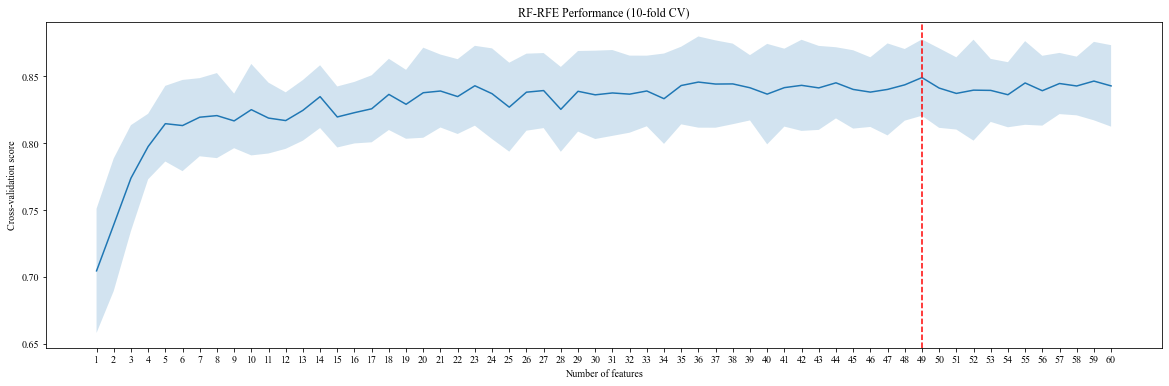

In [69]:
# Plot the mean and standard deviation of the cross-validation scores
plt.figure(dpi=1200)

mean_scores = rfecv.cv_results_['mean_test_score']
std_scores = rfecv.cv_results_['std_test_score']
plt.figure(figsize=(20, 6))
plt.title('RF-RFE Performance (10-fold CV)')
plt.xlabel('Number of features')
plt.ylabel('Cross-validation score')
plt.plot(range(1, len(mean_scores) + 1), mean_scores)
plt.fill_between(range(1, len(mean_scores) + 1), mean_scores - std_scores, mean_scores + std_scores, alpha=0.2)

# Set x-axis ticks to whole numbers only
plt.xticks(range(1, len(mean_scores) + 1))
highest_mean_idx = np.argmax(mean_scores)
plt.axvline(x=highest_mean_idx+1, color='red', linestyle='--')

plt.show()

In [70]:
k_best_features = X_train.columns[rfecv.support_].union(selected_features_chi2).to_list()
k_best_features

['age',
 'checking_status_0_=X_200',
 'checking_status__0',
 'checking_status__=200',
 'checking_status_no checking',
 'credit_amount',
 'credit_history_all paid',
 'credit_history_critical/other existing credit',
 'credit_history_delayed previously',
 'credit_history_existing paid',
 'credit_history_no credits/all paid',
 'duration',
 'employment_1_=X_4',
 'employment_4_=X_7',
 'employment__1',
 'employment__=7',
 'employment_unemployed',
 'existing_credits',
 'housing_for free',
 'housing_own',
 'housing_rent',
 'installment_commitment',
 'job_high qualif/self emp/mgmt',
 'job_skilled',
 'job_unskilled resident',
 'num_dependents',
 'other_parties_none',
 'other_payment_plans_bank',
 'other_payment_plans_none',
 'own_telephone',
 'property_magnitude_car',
 'property_magnitude_life insurance',
 'property_magnitude_no known property',
 'property_magnitude_real estate',
 'purpose_business',
 'purpose_education',
 'purpose_furniture/equipment',
 'purpose_new car',
 'purpose_radio/tv',
 '

## Re-Sampling 

In [71]:
X_train = development_set[k_best_features]
y_train = development_set["class"]

print(f"X Train: {X_train.shape} \ny Train: {y_train.shape}")

X Train: (718, 50) 
y Train: (718,)


In [79]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718 entries, 0 to 717
Data columns (total 50 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   age                                            718 non-null    float64
 1   checking_status_0_=X_200                       718 non-null    int32  
 2   checking_status__0                             718 non-null    int32  
 3   checking_status__=200                          718 non-null    int32  
 4   checking_status_no checking                    718 non-null    int32  
 5   credit_amount                                  718 non-null    float64
 6   credit_history_all paid                        718 non-null    int32  
 7   credit_history_critical/other existing credit  718 non-null    int32  
 8   credit_history_delayed previously              718 non-null    int32  
 9   credit_history_existing paid                   718 non

In [86]:
# cats_var = X_train.select_dtypes(include=['int32']).columns.tolist()

# smote = SMOTENC(categorical_features = cats_var, random_state=42)
# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

cat_cols = X_train.select_dtypes(include=['int32']).columns.tolist()
cat_indices = [X_train.columns.get_loc(col) for col in cat_cols]
smote = SMOTENC(categorical_features=cat_indices, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [87]:
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# Modelling 

In [49]:
def get_dataset(data):
    """
    Splitting dataset (test or dev) into x and ys 
    """
    data.reset_index(drop = True, inplace = True)
    y = data["class"]
    X = data.drop(["class"], axis = 1)
    return X, y

In [50]:
# evaluate a give model using cross-validation
def evaluate_model(X, y, model, n_splits = 5):
    """
    Model cross-validation and evaluation
    k-fold as balanced dataset
    """
    # Tuning cross-validation
    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = 5, random_state = 50)
    
    # Scoring metrics
    scoring = {'accuracy': 'accuracy',
               'precision': 'precision_macro',
               'recall': 'recall_macro',
               'f1_score': 'f1_macro', 
               'ROC AUC': 'roc_auc'}
    
    # Cross-validation
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    # Mean scores
    mean_scores = {key:np.mean(scores[f"test_{key}"]) for key in scoring.keys()}
    
    return mean_scores

In [51]:
def conf_matrix(X, y, name, model):
    """
    Generating Confusion Matrix to observe model accuracy
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 7)
    model.fit(X_train, y_train)
    conf_matrix = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, normalize = "true")
    plt.title(f"{name} Model")
    
    return plt.show()

In [89]:
scores = {}

In [90]:
def main(models, scores = scores, kind = "original"):
    """
    Looping through all models:
    - Scores accuracy (+/- Cross Val Standard Deviation)
    - Generates confusion matrix
    """
    if kind == "original":
        X, y = get_dataset(development_set)
    if kind == "ros":
        X, y = X_train_ros, y_train_ros
    if kind == "smote":
        X, y = X_train_smote, y_train_smote

    for name, model in models.items():
        score = evaluate_model(X, y, model)
        scores[f"({kind}) {name}"] = score
        print(">%s %.3f" % (name, score["accuracy"]))
        conf_matrix(X, y, (f"({kind}) {name}"), model)
        
    return scores 

>Logistic Regression 0.738


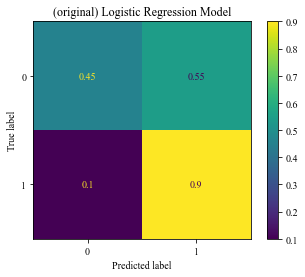

>Random Forest 0.759


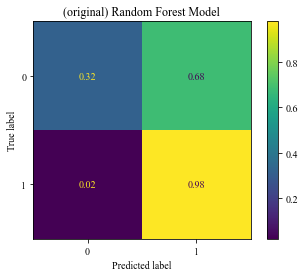

>AdaBoost 0.733


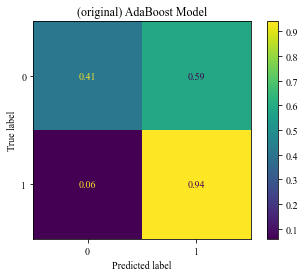

>XGBoost 0.748


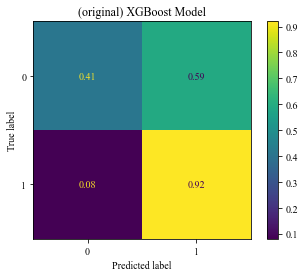

>CatBoost 0.771


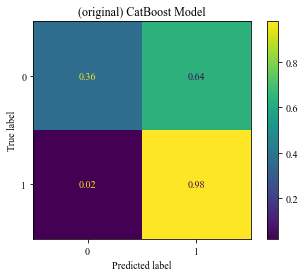

>LightGBM 0.755


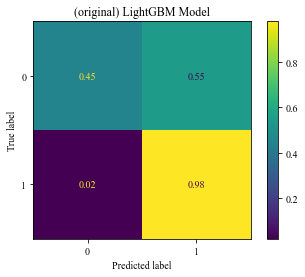

>Neural Network 0.747


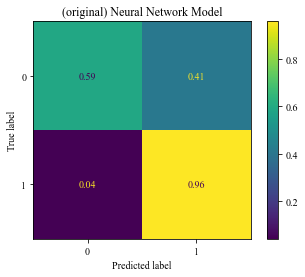

In [91]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(),
    "CatBoost": CatBoostClassifier(verbose=False),
    "LightGBM": LGBMClassifier(),
    "Neural Network": MLPClassifier(),
}

scoring = main(models, kind = "original")

>Logistic Regression 0.716


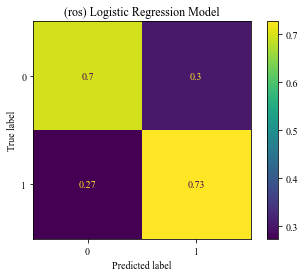

>Random Forest 0.875


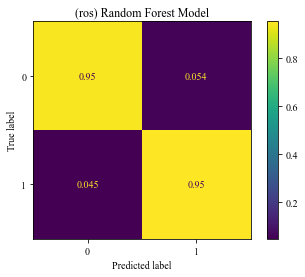

>AdaBoost 0.732


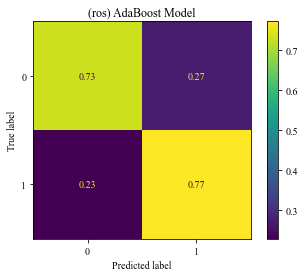

>XGBoost 0.864


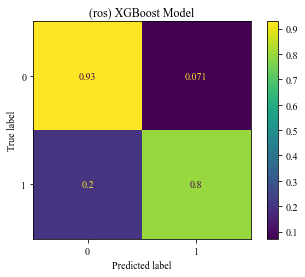

>CatBoost 0.863


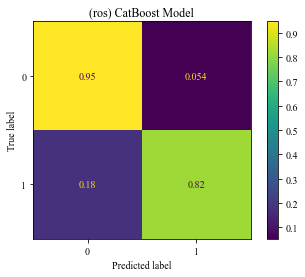

>LightGBM 0.867


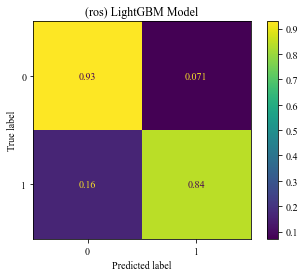

>Neural Network 0.846


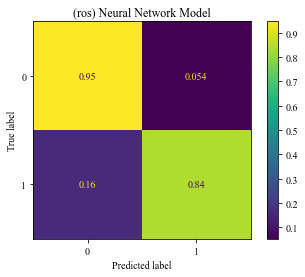

In [92]:
scores = main(models, kind = "ros")

>Logistic Regression 0.811


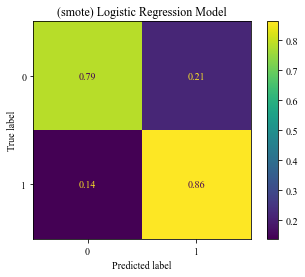

>Random Forest 0.823


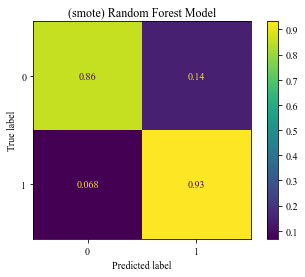

>AdaBoost 0.801


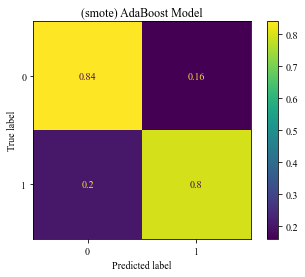

>XGBoost 0.816


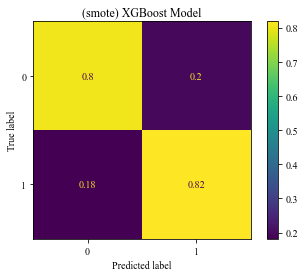

>CatBoost 0.830


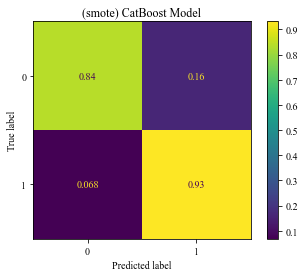

>LightGBM 0.819


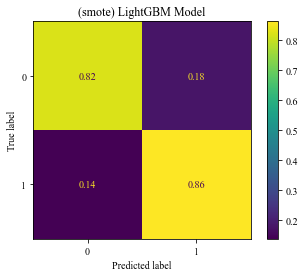

>Neural Network 0.816


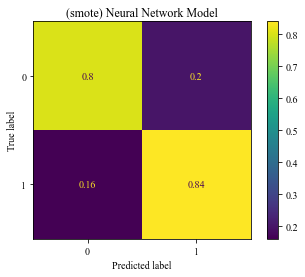

In [93]:
scores = main(models, kind = "smote")

In [94]:
# 10-fold cross-evaluation score on development set

pd.DataFrame.from_dict(scores).T.sort_values("accuracy", ascending=False).head(5)

,accuracy,precision,recall,f1_score,ROC AUC
(ros) Random Forest,0.8754,0.879335,0.8754,0.875048,0.956030
(ros) LightGBM,0.8672,0.871246,0.8672,0.866821,0.943444
(ros) XGBoost,0.8638,0.868468,0.8638,0.863364,0.939592
(ros) CatBoost,0.8634,0.869379,0.8634,0.862821,0.943092
(ros) Neural Network,0.8460,0.851645,0.8460,0.845359,0.903972


Clearly we will employ Random Over-Sampling (ROS), Lets try hyperparameter tune to see an improvement

## Fine-Tuning
### Random Forest Model

In [312]:
optimised_params = {}

In [348]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

X_dev, X_val, y_dev, y_val = train_test_split(X_train_ros, y_train_ros, test_size=0.1, random_state=42)

def objective(trial):
    
    # Define parameters to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 500, 50)
    max_depth = trial.suggest_int('max_depth', 2, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Create random forest classifier with current parameters
    clf = RandomForestClassifier(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  min_samples_split=min_samples_split,
                                  min_samples_leaf=min_samples_leaf,
                                  random_state=42)
    
    # Fit classifier to training data
    clf.fit(X_dev, y_dev)
    
    # Predict labels for test data
    y_pred = clf.predict(X_val)
    
    # Calculate accuracy score
    accuracy = accuracy_score(y_val, y_pred)
    
    # Return accuracy score as objective value to minimize
    return accuracy

In [349]:
# Define Optuna study
study = optuna.create_study(direction='maximize')

# Optimize objective function
study.optimize(objective, n_trials=100)

optimised_params["Random Forest"] = study.best_params

# Print best hyperparameters and accuracy score
print(f'Best parameters: {study.best_params}')
print(f'Best accuracy: {study.best_value}')

print('Best trial:')
trial = study.best_trial
print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('{}: {}'.format(key, value))

Best parameters: {'n_estimators': 500, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 1}
Best accuracy: 0.94
Best trial:
  Value: 0.94
  Params: 
n_estimators: 500
max_depth: 15
min_samples_split: 6
min_samples_leaf: 1


In [350]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
        'gamma': trial.suggest_uniform('gamma', 0, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }
    model = XGBClassifier(**params, random_state=42)
    model.fit(X_dev, y_dev)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    
    return accuracy

# Define Optuna study
study = optuna.create_study(direction='maximize')

# Optimize objective function
study.optimize(objective, n_trials=100)

optimised_params["XGBoost"] = study.best_params

# Print best hyperparameters and accuracy score
print(f'Best parameters: {study.best_params}')
print(f'Best accuracy: {study.best_value}')

print('Best trial:')
trial = study.best_trial
print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Best parameters: {'n_estimators': 800, 'max_depth': 6, 'learning_rate': 0.04558742523460296, 'subsample': 0.39367347324542956, 'colsample_bytree': 0.9990571274873034, 'gamma': 0.20805698801608058, 'min_child_weight': 1}
Best accuracy: 0.93
Best trial:
  Value: 0.93
  Params: 
    n_estimators: 800
    max_depth: 6
    learning_rate: 0.04558742523460296
    subsample: 0.39367347324542956
    colsample_bytree: 0.9990571274873034
    gamma: 0.20805698801608058
    min_child_weight: 1


In [351]:
# Define the objective function for Optuna to minimize
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000, step=100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.01, 10.0),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'random_strength': trial.suggest_loguniform('random_strength', 0.01, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255, step=32),
        'thread_count': 4
    }
    clf = CatBoostClassifier(**params, verbose=False)
    clf.fit(X_dev, y_dev, eval_set=(X_val, y_val), early_stopping_rounds=50)
    preds = clf.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    return accuracy

# Create an Optuna study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Print the best trial and its accuracy
optimised_params["CatBoost"] = study.best_params
best_trial = study.best_trial
print(f"Best trial: {best_trial.params}")
print(f"Accuracy: {best_trial.value}")

Best trial: {'iterations': 400, 'learning_rate': 0.009783414344196315, 'depth': 8, 'l2_leaf_reg': 0.01113732841126813, 'bagging_temperature': 1.0612241009751648, 'random_strength': 0.025404849032910008, 'border_count': 192}
Accuracy: 0.96


## Out-of-Sample 

In [352]:
X_train, y_train = X_train_ros, y_train_ros

In [353]:
test_set[cont_vars] = scaler.transform(test_set[cont_vars])

X_test, y_test = get_dataset(test_set)
print(f"X Test: {X_test.shape} \ny Test: {y_test.shape}")
X_test.head()

X Test: (80, 60) 
y Test: (80,)


,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,own_telephone,foreign_worker,sex,...,housing_own,housing_rent,job_high qualif/self emp/mgmt,job_skilled,job_unemp/unskilled non res,job_unskilled resident,relationship_status_div/dep/mar,relationship_status_div/sep,relationship_status_mar/wid,relationship_status_single
0,-0.072727,-0.01593,1,1,-0.345455,2,1,1,1,0,...,1,0,0,1,0,0,1,0,0,0
1,-0.072727,-0.01593,4,4,-0.345455,2,1,0,1,1,...,0,0,1,0,0,0,0,0,0,1
2,-0.072727,-0.01593,1,2,-0.345455,1,2,1,1,1,...,1,0,1,0,0,0,0,0,0,1
3,-0.072727,-0.01593,4,2,-0.345455,1,1,1,1,1,...,1,0,0,1,0,0,0,1,0,0
4,-0.072727,-0.01593,4,4,-0.345455,1,1,1,1,0,...,1,0,0,1,0,0,1,0,0,0


In [362]:
# Training RF
rf = RandomForestClassifier(**optimised_params["Random Forest"])
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test[k_best_features])

print(classification_report(y_test, rf_pred))
print(roc_auc_score(y_test, rf_pred))

#print(f"f1_score: {f1_score(y_test, rf_pred, average = "macro")}, \nAccuracy: {accuracy_score(y_test, rf_pred)}, \nPrecision: {precision_score(y_test, rf_pred)}, \nRecall: {recall_score(y_test, rf_pred)}")

              precision    recall  f1-score   support

           0       0.71      0.24      0.36        21
           1       0.78      0.97      0.86        59

    accuracy                           0.78        80
   macro avg       0.75      0.60      0.61        80
weighted avg       0.76      0.78      0.73        80

0.6020984665052462


In [363]:
# Training XGBoost
xgb = XGBClassifier(objective='binary:logistic', **optimised_params["XGBoost"])
xgb.fit(X_train, y_train)

xgb_preds = xgb.predict(X_test[k_best_features])

print(classification_report(y_test, xgb_preds))
print(roc_auc_score(y_test, xgb_preds))

              precision    recall  f1-score   support

           0       0.35      0.52      0.42        21
           1       0.80      0.66      0.72        59

    accuracy                           0.62        80
   macro avg       0.58      0.59      0.57        80
weighted avg       0.68      0.62      0.64        80

0.5924132364810332


In [364]:
# Training 
cat = CatBoostClassifier(verbose=False, **optimised_params["CatBoost"])
cat.fit(X_train, y_train)

cat_preds = cat.predict(X_test[k_best_features])

print(classification_report(y_test, cat_preds))
print(roc_auc_score(y_test, cat_preds))

              precision    recall  f1-score   support

           0       0.57      0.19      0.29        21
           1       0.77      0.95      0.85        59

    accuracy                           0.75        80
   macro avg       0.67      0.57      0.57        80
weighted avg       0.72      0.75      0.70        80

0.5698143664245359


In [358]:
# Training CatBoost
cat = CatBoostClassifier(**optimised_params["CatBoost"])
cat.fit(X_train[k_best_features], y_train, verbose=0)

# Training XGBoost
xgb = XGBClassifier(**optimised_params["XGBoost"])
xgb.fit(X_train[k_best_features], y_train)

rf = RandomForestClassifier(**optimised_params["Random Forest"])
rf.fit(X_train, y_train)

# Predictions on the test set
cat_preds = cat.predict(X_test[k_best_features])
xgb_preds = xgb.predict(X_test[k_best_features])
rf_pred = rf.predict(X_test[k_best_features])

# Ensemble predictions using majority vote
ensemble_preds = np.round((cat_preds + xgb_preds + rf_pred) / 3)

# Evaluate the ensemble model
print(classification_report(y_test, ensemble_preds))
print(roc_auc_score(y_test, ensemble_preds))

              precision    recall  f1-score   support

           0       0.60      0.29      0.39        21
           1       0.79      0.93      0.85        59

    accuracy                           0.76        80
   macro avg       0.69      0.61      0.62        80
weighted avg       0.74      0.76      0.73        80

0.6089588377723971


In [251]:
not_selected_cols = data_encoded.columns[~data_encoded.columns.isin(k_best_features)]
not_selected_cols

Index(['foreign_worker', 'class', 'purpose_domestic appliance',
       'purpose_other', 'purpose_repairs', 'purpose_retraining',
       'other_parties_co applicant', 'other_parties_guarantor',
       'other_payment_plans_stores', 'job_unemp/unskilled non res',
       'relationship_status_mar/wid'],
      dtype='object')

In [252]:
len(k_best_features)

50

In [253]:
len(not_selected_cols)

11